In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


In [0]:
import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from  sklearn.metrics import  roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb

In [0]:
pd.set_option('display.max_columns',100)
RFC_METRIC = 'gini'
NUM_ESTIMATORS = 100
NO_JOBS = 4


In [0]:
#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = .20
TEST_SIZE = .20
 #CROSS-VALIDATION
NUMBER_KFOLDS = 5


In [0]:
RANDOM_STATE = 2018
MAX_ROUNDS = 1000 
EARLY_STOP = 50 
OPT_ROUNDS = 1000 
VERBOSE_EVAL = 50 
data_df = pd.read_csv('creditcard.csv')

In [82]:
print("Data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Data -  rows: 118921  columns: 31


In [83]:
data_df.head(9)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0
5,2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0.0
6,4,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0.0
7,7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0.0
8,7,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0.0


In [84]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,118921.000000,118921.000000,118921.000000,118921.000000,118921.000000,118921.000000,118921.000000,118921.000000,118921.000000,118921.000000,118921.000000,118921.000000,118921.000000,118921.000000,118921.000000,118921.000000,118920.000000,118920.000000,118920.000000,118920.000000,118920.000000,118920.000000,118920.000000,118920.000000,118920.000000,118920.000000,118920.000000,118920.000000,118920.000000,118920.000000,118920.000000
mean,47027.170054,-0.253918,-0.010410,0.679130,0.154837,-0.283692,0.090009,-0.114900,0.060152,-0.075959,-0.016671,0.225505,-0.021417,-0.010855,0.040341,0.203001,-0.002599,0.051409,-0.093156,-0.018694,0.043269,-0.035075,-0.113133,-0.035646,0.011230,0.131135,0.027362,0.000798,0.001922,94.481509,0.002060
std,18887.176901,1.838466,1.636283,1.294413,1.336118,1.331991,1.292646,1.192425,1.226151,1.096654,1.050713,1.056796,1.062757,1.018629,0.941505,0.931996,0.888056,0.910053,0.840274,0.812394,0.740780,0.732255,0.637798,0.613552,0.595023,0.439124,0.491152,0.395290,0.317835,256.248844,0.045343
min,0.000000,-56.407510,-72.715728,-33.680984,-5.172595,-42.147898,-26.160506,-31.764946,-73.216718,-9.283925,-18.271168,-4.049895,-17.769143,-5.791881,-19.214325,-4.152532,-13.563273,-25.162799,-9.498746,-7.213527,-21.024817,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.534330,-22.565679,-11.710896,0.000000,0.000000
25%,35608.000000,-1.021676,-0.585565,0.174852,-0.705609,-0.904280,-0.652907,-0.602499,-0.133772,-0.706021,-0.483672,-0.540933,-0.428376,-0.681580,-0.343411,-0.345032,-0.472671,-0.406364,-0.562062,-0.510797,-0.168259,-0.225353,-0.540884,-0.174438,-0.324324,-0.133721,-0.323106,-0.060809,-0.004592,6.890000,0.000000
50%,48852.000000,-0.263647,0.088298,0.753834,0.182457,-0.316332,-0.162771,-0.067083,0.077871,-0.138456,-0.092512,0.145617,0.133732,-0.018517,0.065980,0.315802,0.077273,-0.010744,-0.088328,-0.021881,-0.024914,-0.058568,-0.091361,-0.047882,0.067509,0.168272,-0.064439,0.010841,0.023445,25.000000,0.000000
75%,62467.000000,1.155661,0.754145,1.374919,1.014245,0.242234,0.480686,0.411506,0.370273,0.509519,0.434933,1.042951,0.632629,0.657972,0.471368,0.876824,0.540574,0.446190,0.384351,0.478942,0.168226,0.117267,0.306466,0.082146,0.408446,0.419410,0.293266,0.084915,0.077187,85.000000,0.000000
max,75261.000000,1.960497,18.902453,9.382558,16.715537,34.801666,22.529298,36.677268,20.007208,15.594995,23.745136,12.018913,7.848392,4.465413,10.526766,5.784514,6.098529,9.253526,5.041069,5.228342,39.420904,27.202839,10.503090,19.002942,4.016342,5.541598,3.517346,12.152401,33.847808,19656.530000,1.000000


In [85]:
totl = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Class,V22,Amount,V16,V17,V18,V20,V21,V19,V23,V24,V25,V26,V27,V28,V7,V1,V2,V3,V4,V5,V6,V15,V8,V9,V10,V11,V12,V13,V14,Time
Total,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.000841,0.000841,0.000841,0.000841,0.000841,0.000841,0.000841,0.000841,0.000841,0.000841,0.000841,0.000841,0.000841,0.000841,0.000841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
              xaxis = dict(title = 'Class',showticklabels = True),
              yaxis = dict(title = 'Number of Trasactions'),
              hovermode =  'closest', width =600)
fig = dict(data = data, layout = layout)
iplot(fig, filename = 'class')

In [87]:
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]
#plt.figure(figsize = (14,4))
#plt.title('Credit Card Transactions Time Density Plot')
#sns.set_color_codes("pastel")
#sns.distplot(class_0,kde=True,bins=480)
#sns.distplot(class_1,kde=True,bins=480)
#plt.show()
hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

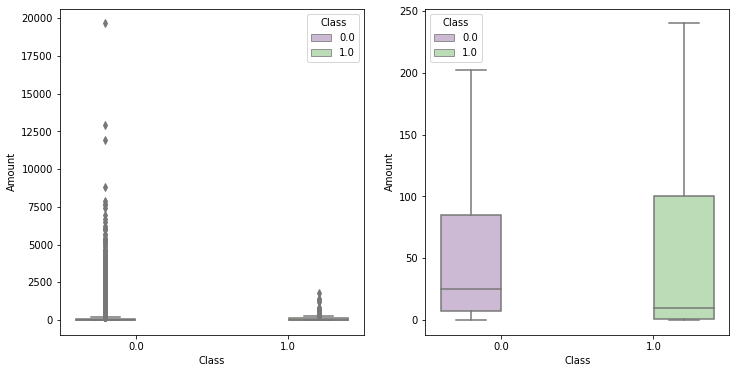

In [88]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [89]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    118675.000000
mean         94.429486
std         256.253714
min           0.000000
25%           6.935000
50%          25.000000
75%          85.000000
max       19656.530000
Name: Amount, dtype: float64

In [90]:
class_1.describe()

count     245.000000
mean      119.680449
std       253.139731
min         0.000000
25%         1.000000
50%         9.990000
75%        99.990000
max      1809.680000
Name: Amount, dtype: float64

In [91]:
fraud = data_df.loc[data_df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

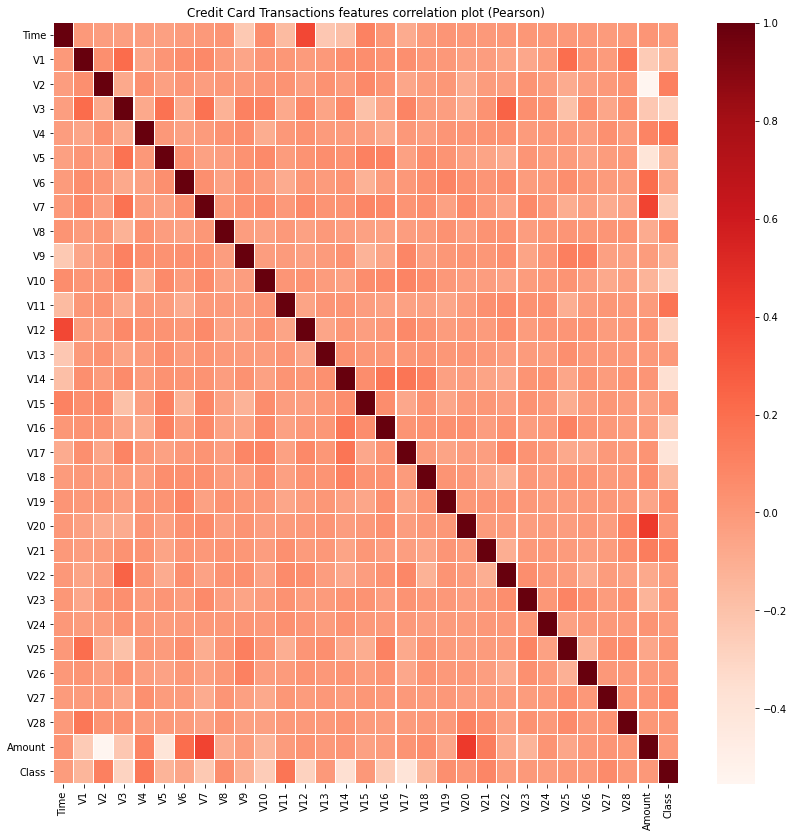

In [92]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

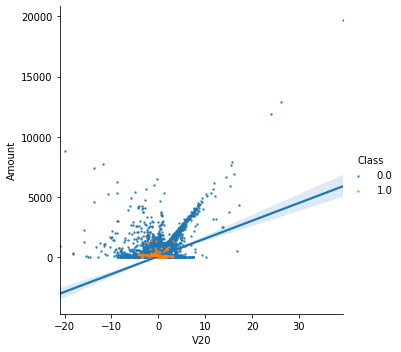

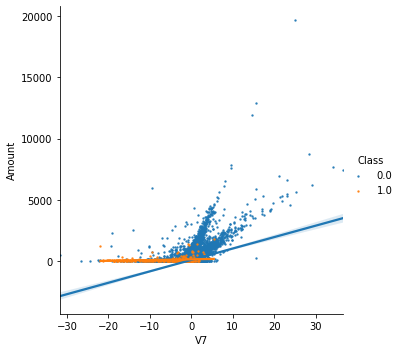

In [93]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

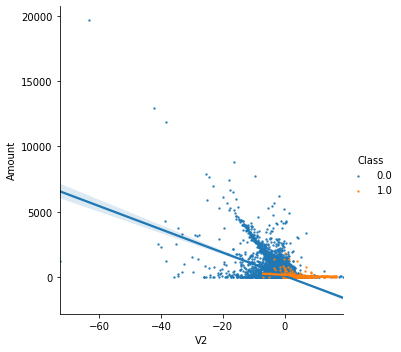

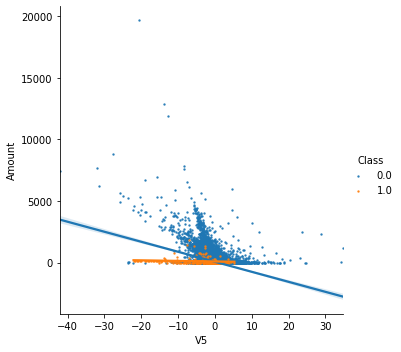

In [94]:
s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning:

Data must have variance to compute a kernel density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning:

Data must have variance to compute a kernel density estimate.



<Figure size 432x288 with 0 Axes>

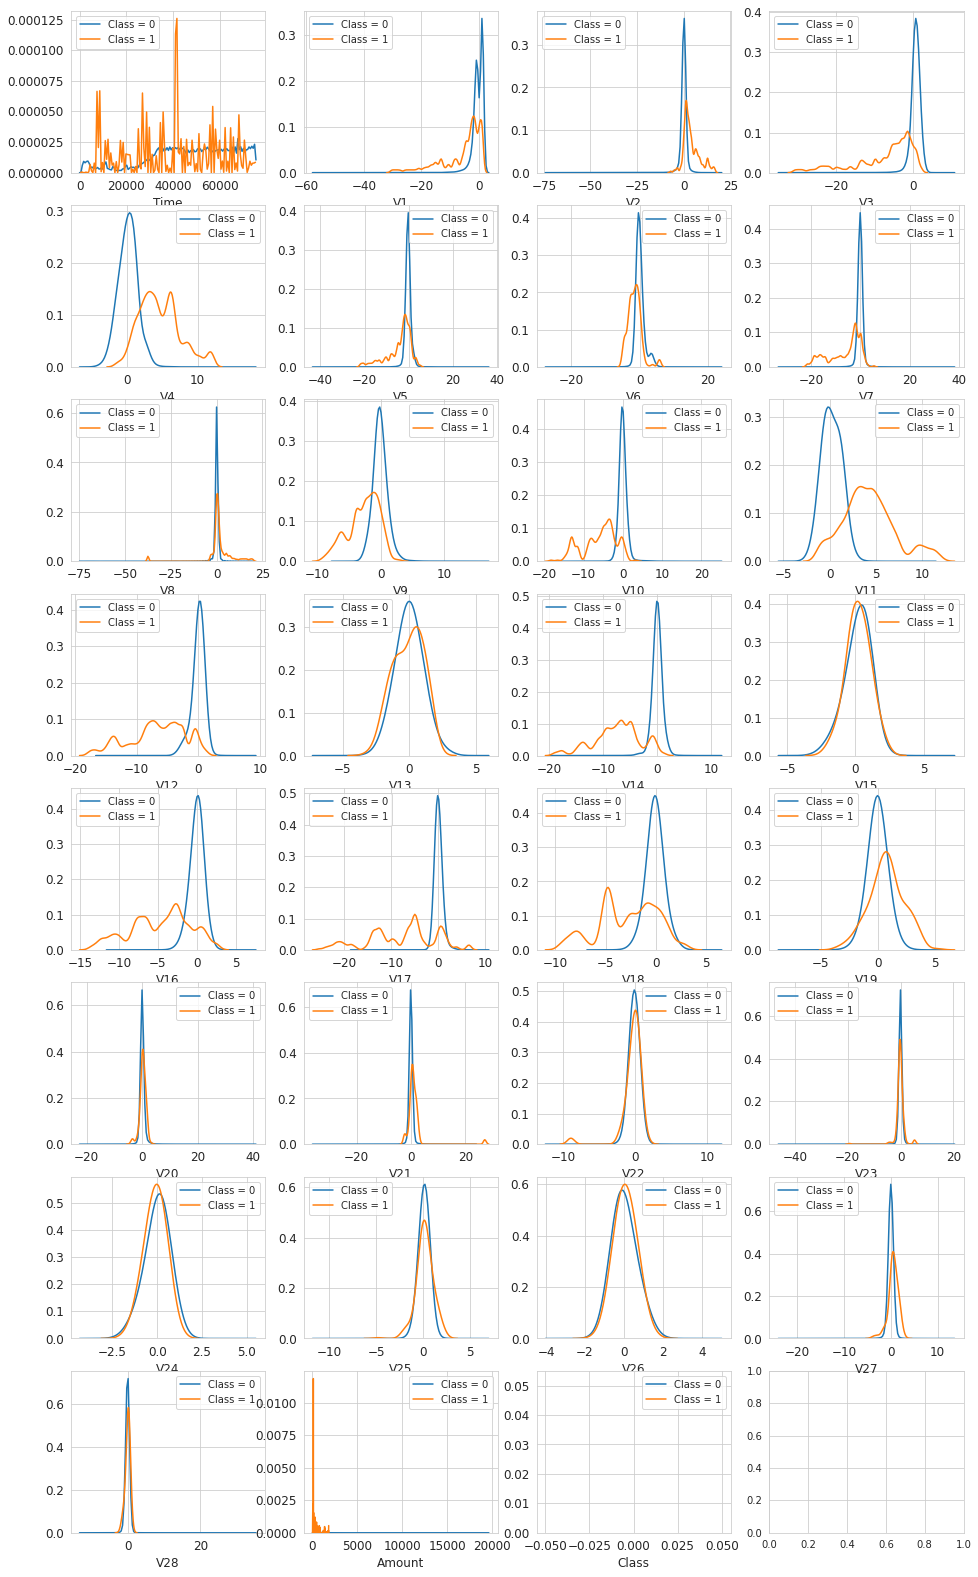

In [95]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

In [0]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [0]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [0]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [0]:
clf.fit(train_df[predictors], train_df[target].values)

In [0]:
preds = clf.predict(valid_df[predictors])

In [0]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [0]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()